<a href="https://colab.research.google.com/github/Pavithra777/GenerativeAI/blob/main/WassersteinGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Issues in basic GAN

1. Mode collapse
  -> A "mode" refers to a peak or distinctive event in a distribution.
  -> Mode collapse occurs when the generator produces the same event or  sample repeatedly in an attempt to deceive the discriminator.
  -> No good correlation between Loss value and the quality of generated image
  -> Flat Distribution:

A flat distribution occurs when the distribution of the target and predictions are very similar.
The gradient becomes flat when the distance between the target and prediction is either very high or very low.
Consequently, it becomes difficult to determine the direction for the gradient to follow.
     

In [ ]:
import torch, torchvision , os, pdb
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
def show(tensor, nums=25,wandactive=0,name=''):
  data = tensor.detach().cpu()
  grid =  make_grid(data[:nums],nrow=5).permute(1,2,0)
  if  wandactive == 1:
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})
  plt.imshow(grid.clip(0,1))
  plt.show()

In [ ]:
device = 'cuda'

n_epochs =10000
batch_size = 128
cur_step = 0
save_step = 35
show_step = 35

lr = 1e-4
z_dim = 200

gen_losses=[]
crit_losses = []
crit_cycles = 5

wandbactive =1


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login(key='7c1e7ed64f98e2718e23ea4d492d726786491622')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%capture

experiment_name = wandb.util.generate_id()

myrun = wandb.init(
    project="wgan",
    group=experiment_name,
    config =  {
        "optimizer":"adam",
        "model":"wgan gp",
        "epochs":1000,
        "batch_size":128
    }
)

config = wandb.config

In [ ]:
print(experiment_name)

e60j0bse


In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim=64,d_dim=16):
    super(Generator,self).__init__()
    self.z_dim = z_dim
    # size = (n-1)*stride - 2*padding+ks
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(z_dim,32*d_dim ,4,1,0), #(1-1)*1 - 2*0 + 4 = 4 # size: 4x4| in_ch : 64| out_ch : 512
        nn.BatchNorm2d(32*d_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(32*d_dim,16*d_dim,4,2,1), # size: 8x8| in_ch : 512| out_ch : 256
        nn.BatchNorm2d(16*d_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(16*d_dim,8*d_dim,4,2,1), # size: 16x16| in_ch : 256| out_ch : 128
        nn.BatchNorm2d(8*d_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(8*d_dim,4*d_dim,4,2,1), # size: 32x32| in_ch : 128| out_ch : 64
        nn.BatchNorm2d(4*d_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(4*d_dim,2*d_dim,4,2,1), # size: 64x64| in_ch : 64| out_ch : 32
        nn.BatchNorm2d(2*d_dim),
        nn.ReLU(True),

        nn.ConvTranspose2d(2*d_dim,3,4,2,1), # size: 128x128| in_ch : 32| out_ch : 3
        nn.Tanh() #produce result in the range -1 to 1
    )

  def forward(self,noise):
    x=noise.view(len(noise),self.z_dim,1,1)
    return self.gen(x)

def generate_noise(num,z_dim,device='cuda'):
  return torch.randn(num,z_dim,device=device)



In [ ]:
class Critic(nn.Module):
  def __init__(self,d_dim=16):
    super(Critic,self).__init__()
    self.z_dim = z_dim
    # size = ((n+2*padding-ks)//stride) + 1
    self.critic = nn.Sequential(
        nn.Conv2d(3,d_dim,4,2,1), # size = ((128+2*1-4)//2)+1 = 64x64| in_ch : 3| out_ch : 16
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(d_dim,2*d_dim,4,2,1), # size: 32x32|in_ch : 16| out_ch : 32
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(2*d_dim,4*d_dim ,4,2,1), # size: 16x16| in_ch : 32| out_ch : 64
        nn.InstanceNorm2d(4*d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(4*d_dim,8*d_dim  ,4,2,1), # size: 8x8| in_ch : 64| out_ch : 128
        nn.InstanceNorm2d(8*d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(8*d_dim,16*d_dim ,4,2,1),  # size: 4x4| in_ch : 128| out_ch : 256
        nn.InstanceNorm2d(16*d_dim),
        nn.LeakyReLU(0.2),

        nn.Conv2d(16*d_dim,1,4,1,0),  # size: 1x1| in_ch : 256| out_ch : 1

    )

  def forward(self,image):
    critic_pred = self.critic(image)
    return critic_pred.view(len(critic_pred),-1)


In [ ]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weights,0.0,0.02)
    torch.nn.init.constant_(m.bias,0)

  if isinstance(m,nn.BatchNorm2d) :
    torch.nn.init.normal_(m.weights,0.0,0.02)
    torch.nn.init.constant_(m.bias,0)


#gen=gen.apply(init_weights)
#critic=critic.apply(init_weights)

In [ ]:
import gdown, zipfile
#https://drive.google.com/file/d/1LBmIIPhpAObuWnfZ7rC0EyHH3BkHbye7/view?usp=sharing
file_id = "1LBmIIPhpAObuWnfZ7rC0EyHH3BkHbye7"
url = f"https://drive.google.com/uc?id={file_id}"
path = 'data/celeba'
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url,download_path,quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1LBmIIPhpAObuWnfZ7rC0EyHH3BkHbye7
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:29<00:00, 49.5MB/s]


In [ ]:
with zipfile.ZipFile(download_path,'r') as ziphandler:
  ziphandler.extractall(path)


KeyboardInterrupt: ignored

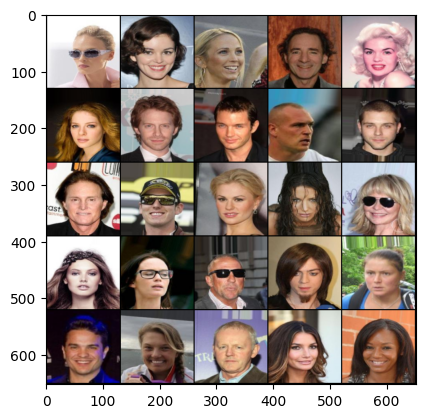

In [ ]:
class Dataset(Dataset):
  def __init__(self,path,size=128,limit=10000):
    self.sizes = [size,size]
    items,labels = [],[]
    for data in os.listdir(path)[:limit]:
      items.append(os.path.join(path,data))
      labels.append(data)
    self.items = items
    self.labels =  labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data =  Image.open(self.items[idx]).convert('RGB')
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))
    data = np.transpose(data,(2,0,1)).astype(np.float32,copy=False)
    data = torch.from_numpy(data).div(255)
    return data,self.labels[idx]

## Dataset
data_path = './data/celeba/img_align_celeba'
ds = Dataset(data_path,size=128,limit=10000)

## DataLoader
dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True)

## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt= torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

##wandb

if wandbactive == 1:
  wandb.watch(gen,log_freq=100)
  wandb.watch(crit,log_freq=100)

images,labels = next(iter(dataloader))
show(images)


In [ ]:
def get_gp(real,fake,critic,alpha,gamma=10):
  mix_images = alpha * real+(1 - alpha) * fake
  mix_scores = critic(mix_images)
  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs = torch.ones_like(mix_scores),
      retain_graph = True,
      create_graph = True
  )[0]
  gradient= gradient.view(len(gradient),-1)
  gradient_norm = gradient.norm(2,dim=1)
  gp = gamma*((gradient_norm -1)**2).mean()
  return gp

In [ ]:
root_path = './data/'
def save_checkpoint(name):
  torch.save(
      {
          "epoch":epoch,
          "model_state_dict":gen.state_dict(),
          "optimizer_state_dict":gen_opt.state_dict(),

      },f"{root_path}G-{name}.pkl"
  )

  torch.save(
      {
          "epoch":epoch,
          "model_state_dict":crit.state_dict(),
          "optimizer_state_dict":crit_opt.state_dict(),

      },f"{root_path}C-{name}.pkl"
  )
  print("checkpoint saved")
def load_checkpoint(name):
  checkpoints=torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoints["model_state_dict"])
  gen_opt.load_state_dict(checkpoints["optimizer_state_dict"])

  checkpoints=torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoints["model_state_dict"])
  crit_opt.load_state_dict(checkpoints["optimizer_state_dict"])
  print("checkpoint loaded")

In [ ]:
# epoch =1
# save_checkpoint("test")
# load_checkpoint("test")

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


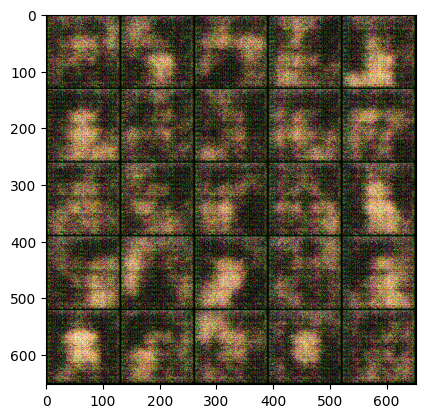

Epoch : 0 , Step : 35 , Generator Loss : 12.939382945214 , Critic Loss : -14.50117534637451


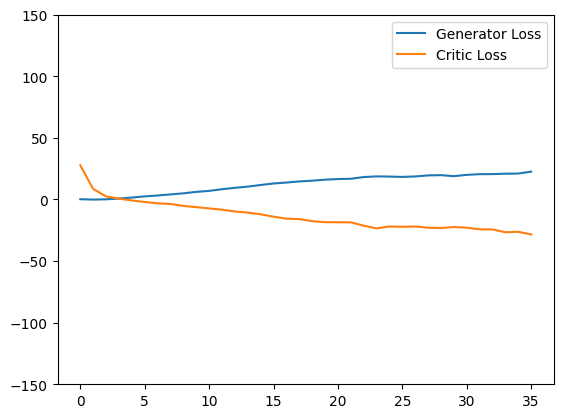

checkpoint saved


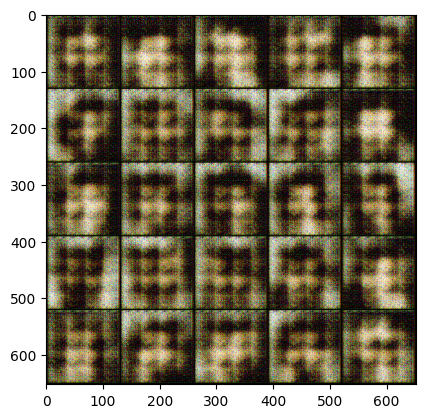

Epoch : 0 , Step : 70 , Generator Loss : 24.750579125540597 , Critic Loss : -27.78670400347028


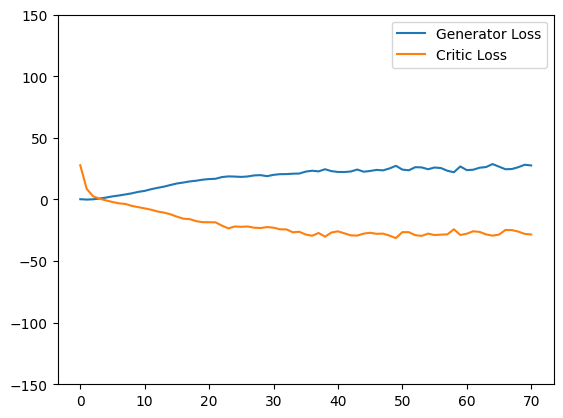

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


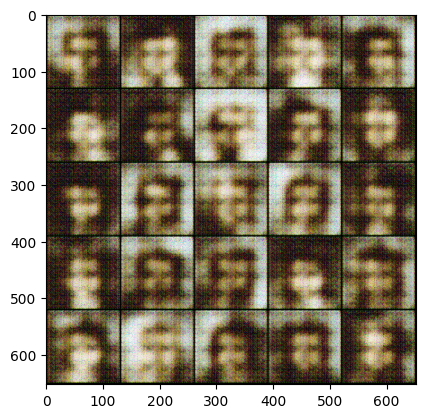

Epoch : 1 , Step : 105 , Generator Loss : 27.73350748334612 , Critic Loss : -24.586648668561665


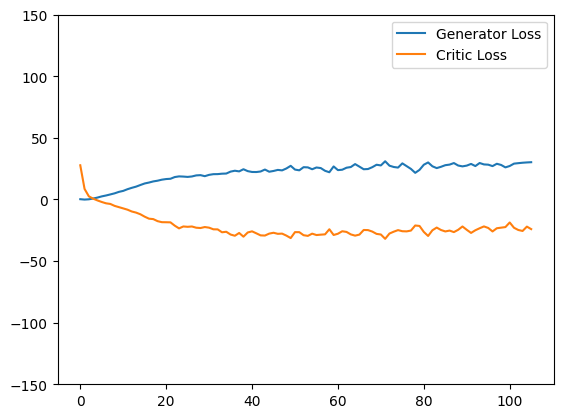

checkpoint saved


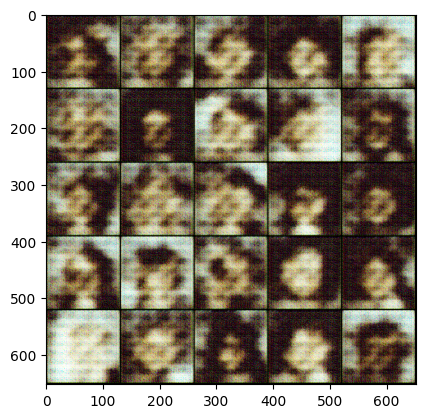

Epoch : 1 , Step : 140 , Generator Loss : 28.56018137250628 , Critic Loss : -22.427156415666843


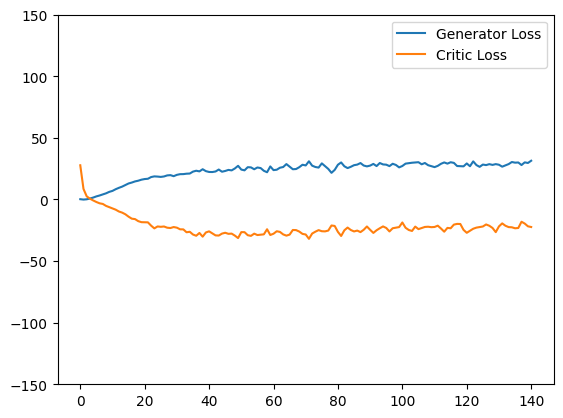

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


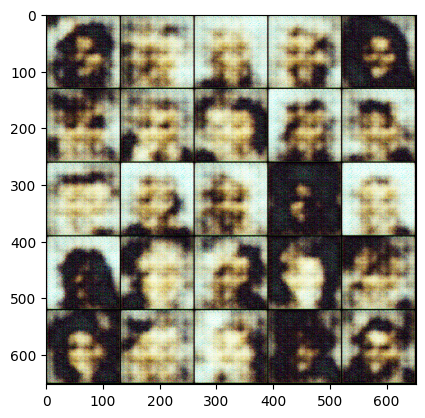

Epoch : 2 , Step : 175 , Generator Loss : 29.683364159720284 , Critic Loss : -21.63273229871478


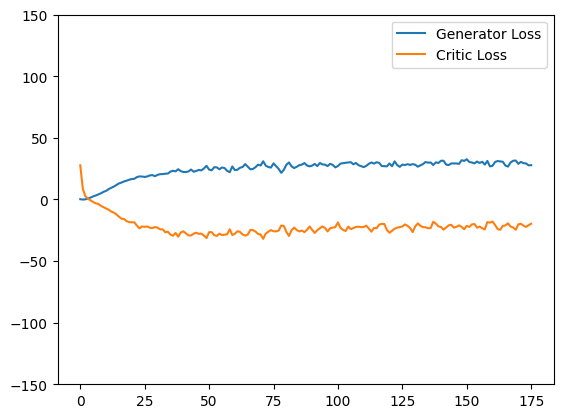

checkpoint saved


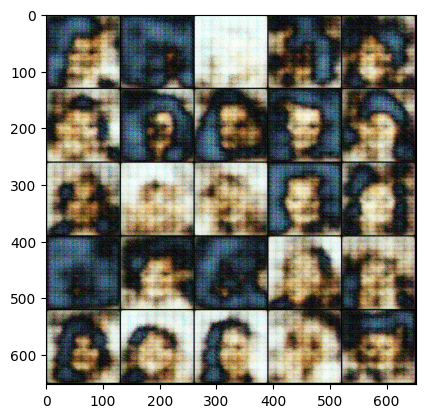

Epoch : 2 , Step : 210 , Generator Loss : 23.257695606776647 , Critic Loss : -18.91834847041539


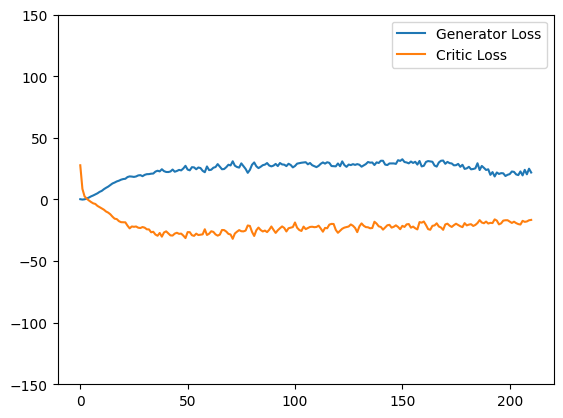

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


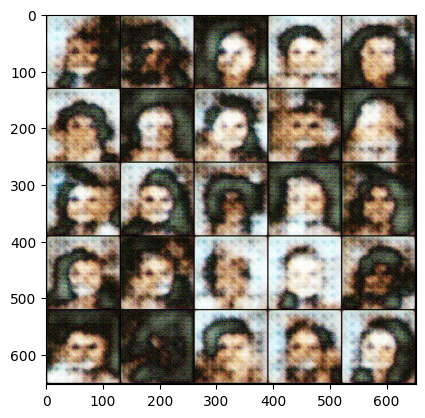

Epoch : 3 , Step : 245 , Generator Loss : 23.538850566319056 , Critic Loss : -17.276167962210515


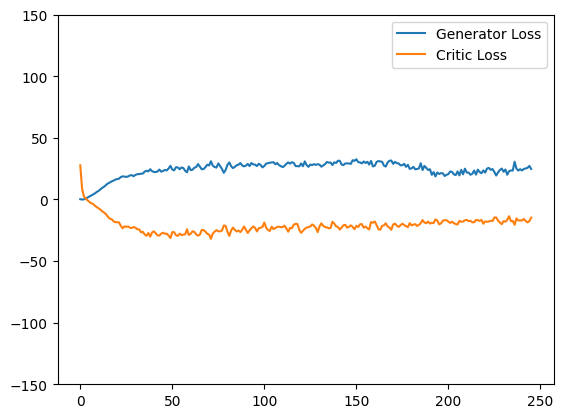

checkpoint saved


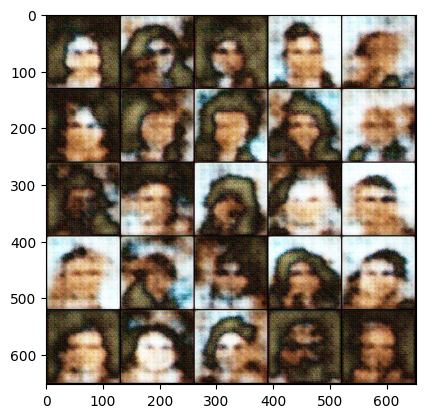

Epoch : 3 , Step : 280 , Generator Loss : 24.244082151140486 , Critic Loss : -15.775186587742395


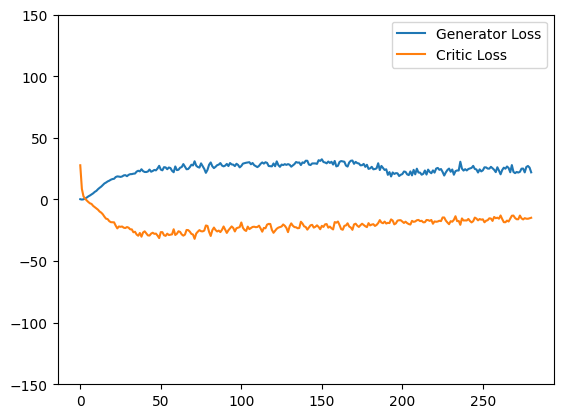

checkpoint saved


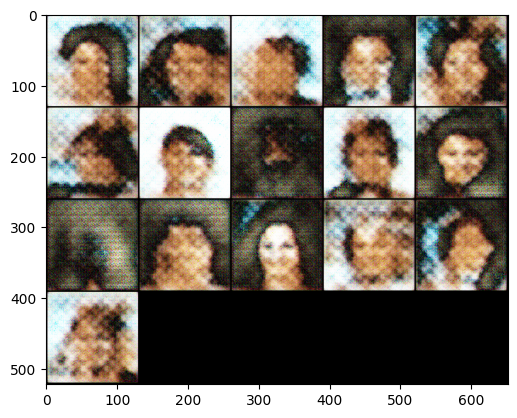

Epoch : 3 , Step : 315 , Generator Loss : 23.532606996808735 , Critic Loss : -14.61395798546927


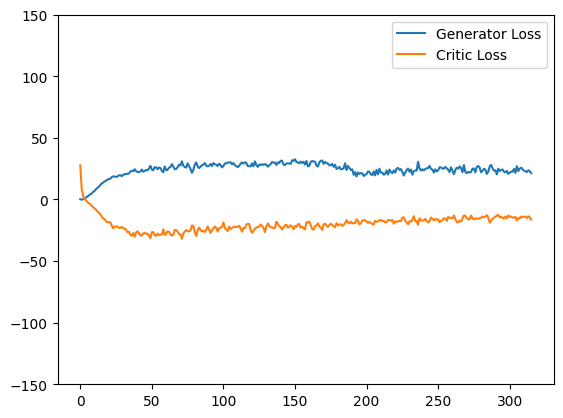

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


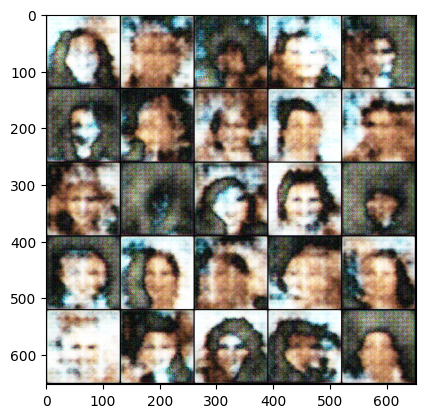

Epoch : 4 , Step : 350 , Generator Loss : 23.566562598092215 , Critic Loss : -14.199391076224188


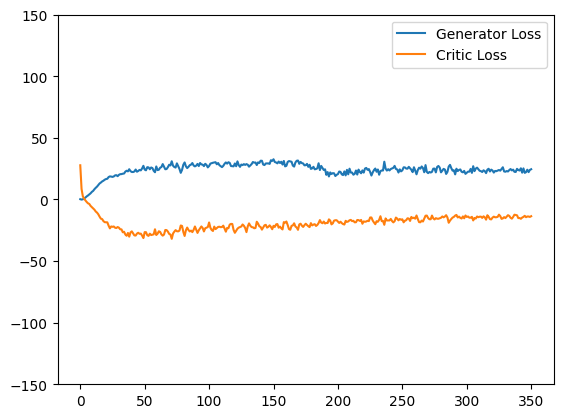

checkpoint saved


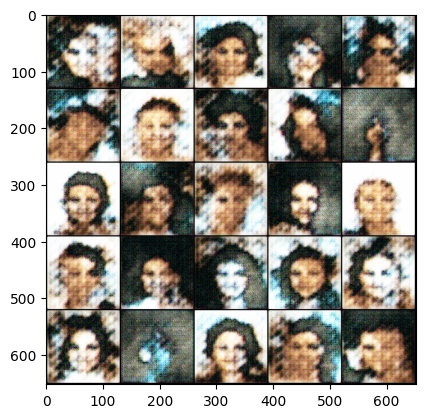

Epoch : 4 , Step : 385 , Generator Loss : 23.198538371494838 , Critic Loss : -13.242951627458844


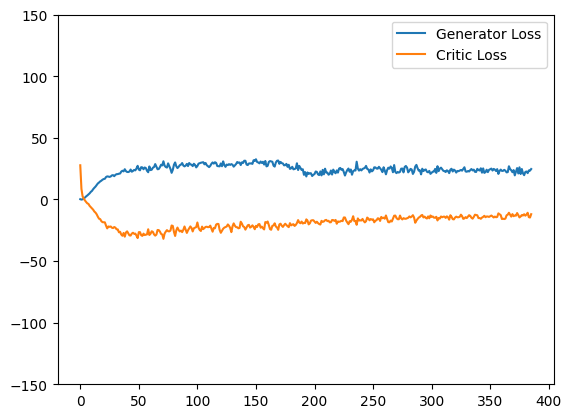

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


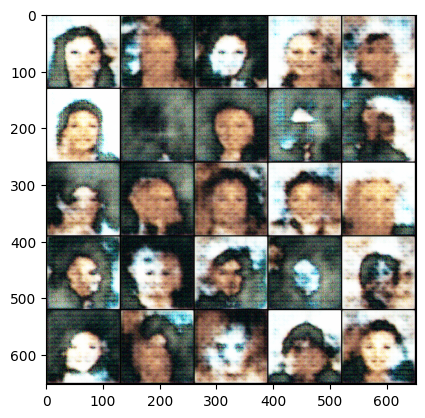

Epoch : 5 , Step : 420 , Generator Loss : 22.50917658124651 , Critic Loss : -12.609181829180034


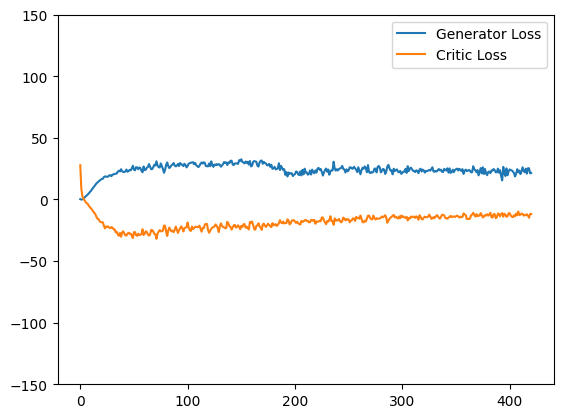

checkpoint saved


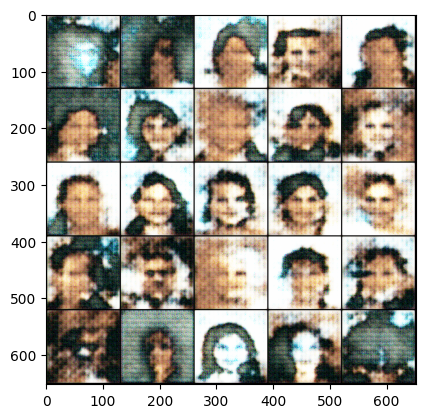

Epoch : 5 , Step : 455 , Generator Loss : 21.936667360578266 , Critic Loss : -12.18567303793771


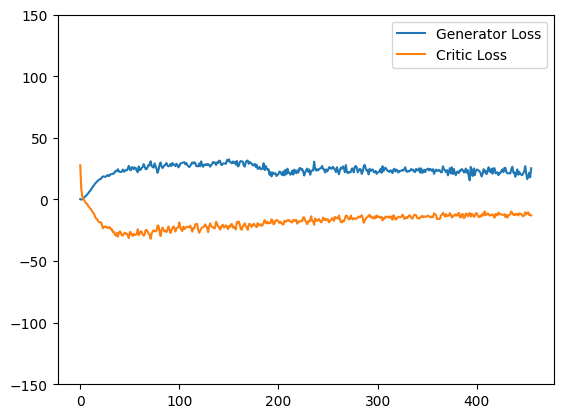

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


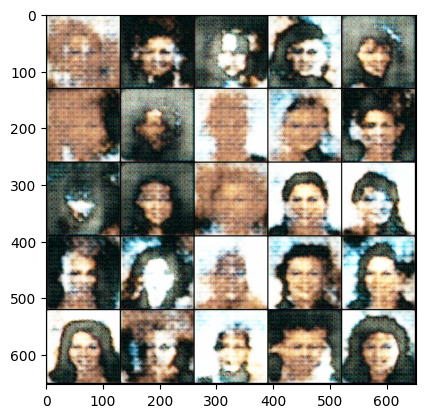

Epoch : 6 , Step : 490 , Generator Loss : 21.66537192208426 , Critic Loss : -11.895200849260602


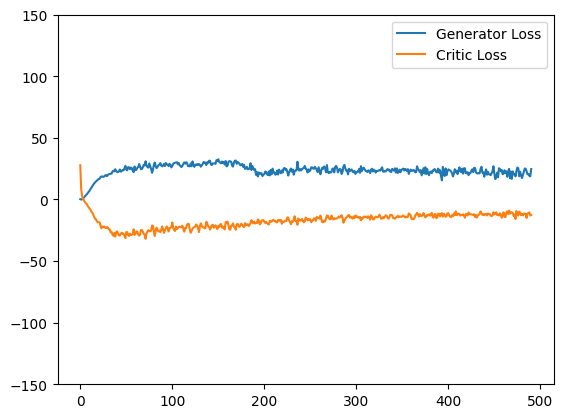

checkpoint saved


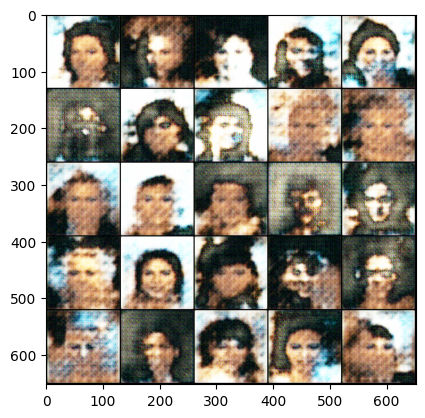

Epoch : 6 , Step : 525 , Generator Loss : 21.289386204310826 , Critic Loss : -11.071793659755164


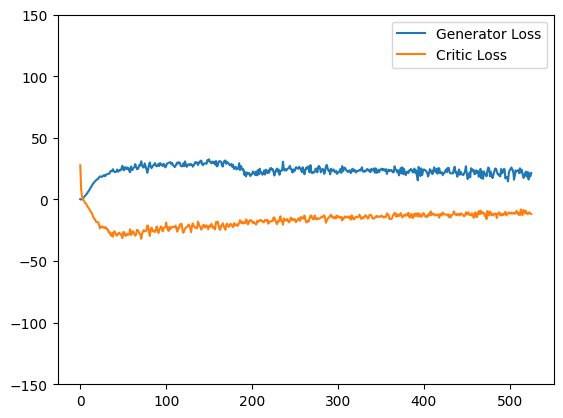

  0%|          | 0/79 [00:00<?, ?it/s]

checkpoint saved


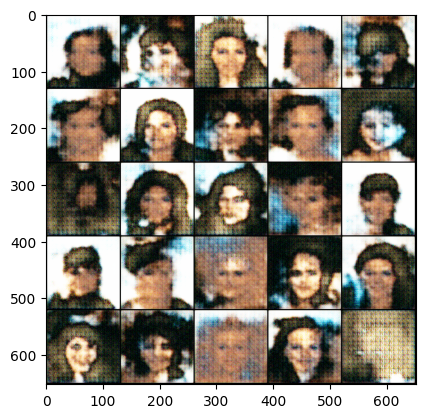

Epoch : 7 , Step : 560 , Generator Loss : 19.721128845214842 , Critic Loss : -10.596596772330148


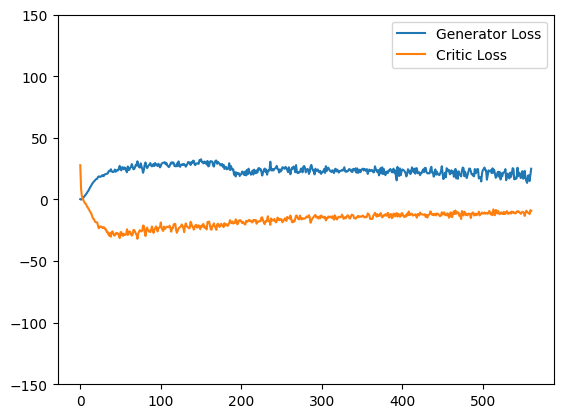

checkpoint saved


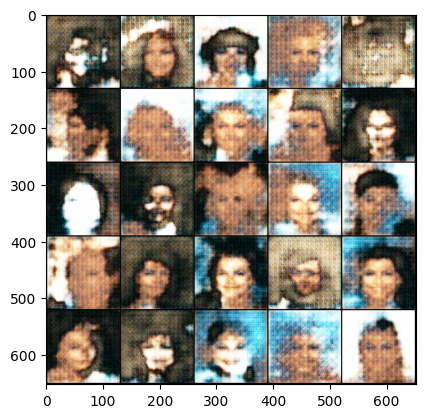

Epoch : 7 , Step : 595 , Generator Loss : 20.574146025521415 , Critic Loss : -10.479188548496792


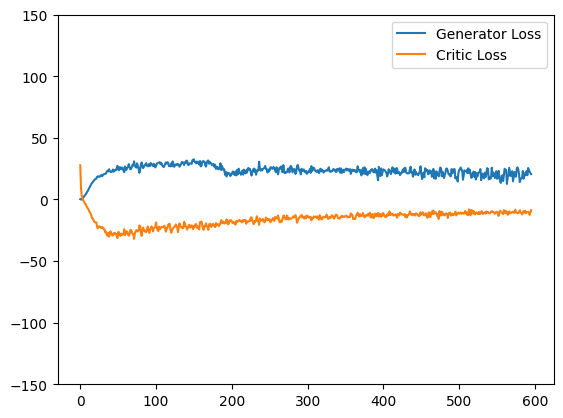

In [ ]:
for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    cur_bs = len(real)
    real = real.to(device)

    ## Critic
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = generate_noise(cur_bs,z_dim)
      fake = gen(noise)

      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.randn(len(real),1,1,1,device = device , requires_grad = True)
      gp = get_gp(real,fake.detach(),crit,alpha)
      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp

      mean_crit_loss += crit_loss.item() / crit_cycles
      crit_loss.backward(retain_graph=True)
      crit_opt.step()
    crit_losses += [mean_crit_loss]

    ## Generator
    gen_opt.zero_grad()
    noise = generate_noise(cur_bs,z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)
    gen_loss = - crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()
    gen_losses+=[gen_loss.item()]

    if wandbactive == 1:
      wandb.log({'Epoch': epoch, 'Step' : cur_step, 'Generator Loss' : gen_loss , 'Critic Losses' : mean_crit_loss})

    if cur_step % save_step == 0 and cur_step > 0:
      save_checkpoint('Latest')

    if cur_step % show_step == 0 and cur_step > 0:
      #show(real, wandactive=0,name='real')
      show(fake, wandactive=1,name='fake')

      gen_mean = sum(gen_losses[-show_step:])/show_step
      crit_mean = sum(crit_losses[-show_step:])/show_step

      print(f"Epoch : {epoch} , Step : {cur_step} , Generator Loss : {gen_mean} , Critic Loss : {crit_mean}")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

      plt.plot(
          range(len(crit_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

      plt.ylim(-150,150)
      plt.legend()
      plt.show()

    cur_step+=1



In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

# MORPHING, interpolation between points in latent space
gen_set=[]
z_shape=[1,200,1,1]
rows=4
steps=17

for i in range(rows):
  z1,z2 = torch.randn(z_shape), torch.randn(z_shape)
  for alpha in np.linspace(0,1,steps):
    z=alpha*z1 + (1-alpha)*z2
    res=gen(z.cuda())[0]
    gen_set.append(res)

fig = plt.figure(figsize=(25,11))
grid=ImageGrid(fig, 111, nrows_ncols=(rows,steps), axes_pad=0.1)

for ax , img in zip (grid, gen_set):
  ax.axis('off')
  res=img.cpu().detach().permute(1,2,0)
  res=res-res.min()
  res=res/(res.max()-res.min())
  ax.imshow(res.clip(0,1.0))

plt.show()